In [1]:
from datasets import load_dataset

data = load_dataset("nahiar/twitter_bot_detection")

# Or convert to pandas DataFrame to use head()
df = data["train"].to_pandas()
df.head()

/Users/rhd/Documents/Raihan/Work/Data/Model-ML/bot-detection-twitter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",None,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


# Data Exploration

## Summary

In [2]:
columns = df.info()
print("Dataset Columns:", columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    37438 non-null  int64  
 1   created_at                    37438 non-null  object 
 2   default_profile               37438 non-null  bool   
 3   default_profile_image         37438 non-null  bool   
 4   description                   30181 non-null  object 
 5   favourites_count              37438 non-null  int64  
 6   followers_count               37438 non-null  int64  
 7   friends_count                 37438 non-null  int64  
 8   geo_enabled                   37438 non-null  bool   
 9   id                            37438 non-null  int64  
 10  lang                          29481 non-null  object 
 11  location                      37434 non-null  object 
 12  profile_background_image_url  32939 non-null  object 
 13  p

In [3]:
# find missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Unnamed: 0                         0
created_at                         0
default_profile                    0
default_profile_image              0
description                     7257
favourites_count                   0
followers_count                    0
friends_count                      0
geo_enabled                        0
id                                 0
lang                            7957
location                           4
profile_background_image_url    4499
profile_image_url                  1
screen_name                        0
statuses_count                     0
verified                           0
average_tweets_per_day             0
account_age_days                   0
account_type                       0
dtype: int64


In [4]:
print(f"Train samples: {len(df)}")

Train samples: 37438


In [5]:
# tampilkan masing masing column itu tuh kayak yang unique value nya berapa
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}: {len(unique_values)}")

Unnamed: 0: 37438
created_at: 37430
default_profile: 2
default_profile_image: 2
description: 29945
favourites_count: 15004
followers_count: 13210
friends_count: 5301
geo_enabled: 2
id: 37438
lang: 49
location: 12050
profile_background_image_url: 21
profile_image_url: 36881
screen_name: 37438
statuses_count: 19189
verified: 2
average_tweets_per_day: 12636
account_age_days: 4156
account_type: 2


# Preprocessing

In [6]:
# --- FITUR YANG SUDAH ANDA BUAT (INI BAGUS, KITA PERTAHANKAN) ---
df["is_bot"] = df["account_type"].map({"human": 0, "bot": 1})
df["follower_following_ratio"] = df["followers_count"] / df["friends_count"].replace(
    0, 1
)

# --- PENINGKATAN & FITUR BARU ---

# 1. Dari kolom 'description'
# bio_length sudah bagus, mari kita tambahkan lagi. Bot seringkali tidak punya bio atau punya bio yang sangat pendek.
df["bio_length"] = df["description"].apply(lambda x: len(str(x)))


# 2. Dari kolom 'screen_name'
# Panjang username dan jumlah digit di dalamnya adalah sinyal klasik untuk akun bot/spam.
df["username_length"] = df["screen_name"].apply(lambda x: len(str(x)))
df["username_digit_count"] = df["screen_name"].apply(
    lambda x: sum(c.isdigit() for c in str(x))
)

# 3. Dari kolom boolean/lainnya
# has_profile_picture sudah bagus, mari kita buat lebih eksplisit namanya.
df["has_custom_profile_image"] = df["default_profile_image"].apply(
    lambda x: 0 if x else 1
)
# Apakah pengguna punya background kustom? Bot biasanya tidak.
df["has_custom_background"] = df["profile_background_image_url"].apply(
    lambda x: 0 if "default_profile" in str(x) or "theme1/bg.png" in str(x) else 1
)
# Apakah ada info lokasi?
df["has_location"] = df["location"].apply(
    lambda x: 0 if str(x).lower() in ["unknown", "none", ""] else 1
)
# Apakah Default Profile True? jika iya maka 0
df["is_default_profile"] = df["default_profile"].apply(lambda x: 0 if x else 1)

# Apakah geo_enabled? Jika iya maka 1, jika tidak maka 0
df["is_geo_enabled"] = df["geo_enabled"].apply(lambda x: 1 if x else 0)

# Apakah verified? Jika iya maka 1, jika tidak maka 0
df["is_verified"] = df["verified"].apply(lambda x: 1 if x else 0)

# Menampilkan 10 data teratas dengan fitur baru
df.head(10)

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,...,follower_following_ratio,bio_length,username_length,username_digit_count,has_custom_profile_image,has_custom_background,has_location,is_default_profile,is_geo_enabled,is_verified
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,...,397.250000,129,15,0,1,0,0,1,0,0
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,...,0.977273,160,12,0,1,0,1,1,0,0
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,...,0.289562,81,8,0,1,0,1,1,1,0
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,...,0.816746,97,13,1,1,1,1,0,1,0
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,...,6497.224138,36,13,0,1,0,1,1,1,1
5,5,2016-11-21 22:50:30,True,False,لا إله إلا الله . فعل التنبيهات 🌷🎖عادل ...حساب...,237,27394,542,False,800833795234611200,...,50.542435,60,8,3,1,1,1,0,0,0
6,6,2009-07-08 22:22:59,False,False,"Co-Host of @TheTalkCBS, Judge on @DancingABC, ...",5522,291529,1581,True,55050269,...,184.395319,150,14,0,1,1,1,1,1,1
7,7,2012-09-07 20:01:33,False,False,Internationally-acclaimed Egyptian Singer.,756,6909959,40,False,809500704,...,172748.975000,42,7,0,1,0,0,1,0,1
8,8,2012-12-16 11:43:24,True,False,None,64,24,0,False,1015021614,...,24.000000,4,14,0,1,0,0,0,0,0
9,9,2012-02-14 15:33:48,False,False,Man Utd fan. mostly here for football. Takes p...,36384,2130,3363,True,492306486,...,0.633363,117,10,0,1,1,1,1,1,0


## Remove Unused Columns

In [7]:
df.drop(
    columns=[
        "location",
        "profile_background_image_url",
        "default_profile_image",
        "screen_name",
        "description",
        "Unnamed: 0",
        "created_at",
        "id",
        "lang",
        "geo_enabled",
        "verified",
        "default_profile",
        "profile_image_url"
    ],
    inplace=True,
)
print("Columns after removal:", df.columns)
df.head(10)

Columns after removal: Index(['favourites_count', 'followers_count', 'friends_count',
       'statuses_count', 'average_tweets_per_day', 'account_age_days',
       'account_type', 'is_bot', 'follower_following_ratio', 'bio_length',
       'username_length', 'username_digit_count', 'has_custom_profile_image',
       'has_custom_background', 'has_location', 'is_default_profile',
       'is_geo_enabled', 'is_verified'],
      dtype='object')


,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days,account_type,is_bot,follower_following_ratio,bio_length,username_length,username_digit_count,has_custom_profile_image,has_custom_background,has_location,is_default_profile,is_geo_enabled,is_verified
0,4,1589,4,11041,7.870,1403,bot,1,397.250000,129,15,0,1,0,0,1,0,0
1,536,860,880,252,0.183,1379,human,0,0.977273,160,12,0,1,0,1,1,0,0
2,3307,172,594,1001,0.864,1159,human,0,0.289562,81,8,0,1,0,1,1,1,0
3,8433,517,633,1324,0.889,1489,human,0,0.816746,97,13,1,1,1,1,0,1,0
4,88,753678,116,4202,1.339,3138,human,0,6497.224138,36,13,0,1,0,1,1,1,1
5,237,27394,542,11513,8.428,1366,bot,1,50.542435,60,8,3,1,1,1,0,0,0
6,5522,291529,1581,14535,3.581,4059,human,0,184.395319,150,14,0,1,1,1,1,1,1
7,756,6909959,40,1223,0.421,2902,human,0,172748.975000,42,7,0,1,0,0,1,0,1
8,64,24,0,277,0.099,2802,human,0,24.000000,4,14,0,1,0,0,0,0,0
9,36384,2130,3363,63376,20.391,3108,human,0,0.633363,117,10,0,1,1,1,1,1,0


# Data Visualization & Analysis

Let's create comprehensive visualizations to understand our bot detection dataset better.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

In [9]:
# Define feature groups for analysis and modeling
numeric_features = [
    'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
    'average_tweets_per_day', 'account_age_days', 'follower_following_ratio',
    'bio_length', 'username_length', 'username_digit_count'
]

binary_features = [
    'has_custom_profile_image', 'has_custom_background', 'has_location',
    'is_default_profile', 'is_geo_enabled', 'is_verified'
]

all_features = numeric_features + binary_features

print("Numeric Features:", len(numeric_features))
print(numeric_features)
print("\nBinary Features:", len(binary_features))
print(binary_features)
print(f"\nTotal Features for Model: {len(all_features)}")

Numeric Features: 10
['favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'average_tweets_per_day', 'account_age_days', 'follower_following_ratio', 'bio_length', 'username_length', 'username_digit_count']

Binary Features: 6
['has_custom_profile_image', 'has_custom_background', 'has_location', 'is_default_profile', 'is_geo_enabled', 'is_verified']

Total Features for Model: 16


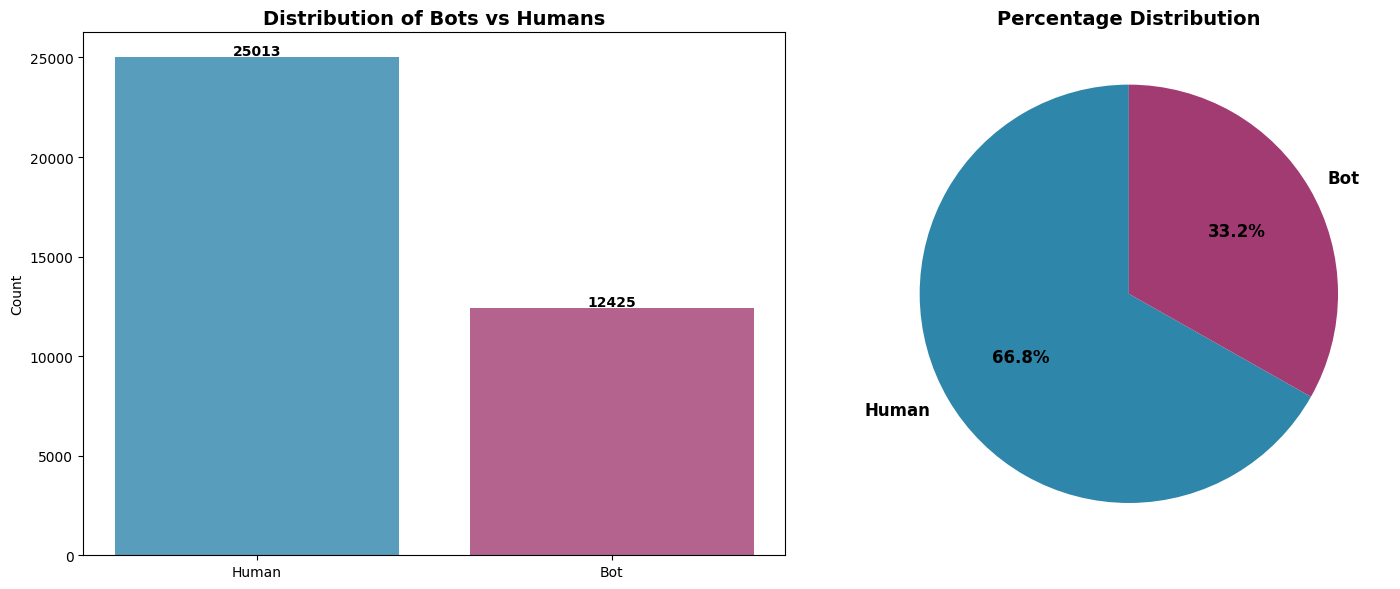

Total samples: 37,438
Bots: 12,425 (33.2%)
Humans: 25,013 (66.8%)
Bot to Human ratio: 1:2.0


In [10]:
# 1. Bot vs Human Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
bot_counts = df['is_bot'].value_counts()
labels = ['Human', 'Bot']
colors = ['#2E86AB', '#A23B72']

axes[0].bar(labels, bot_counts.values, color=colors, alpha=0.8)
axes[0].set_title('Distribution of Bots vs Humans', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(bot_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(bot_counts.values, labels=labels, colors=colors, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total samples: {len(df):,}")
print(f"Bots: {bot_counts[1]:,} ({bot_counts[1]/len(df)*100:.1f}%)")
print(f"Humans: {bot_counts[0]:,} ({bot_counts[0]/len(df)*100:.1f}%)")
print(f"Bot to Human ratio: 1:{bot_counts[0]/bot_counts[1]:.1f}")

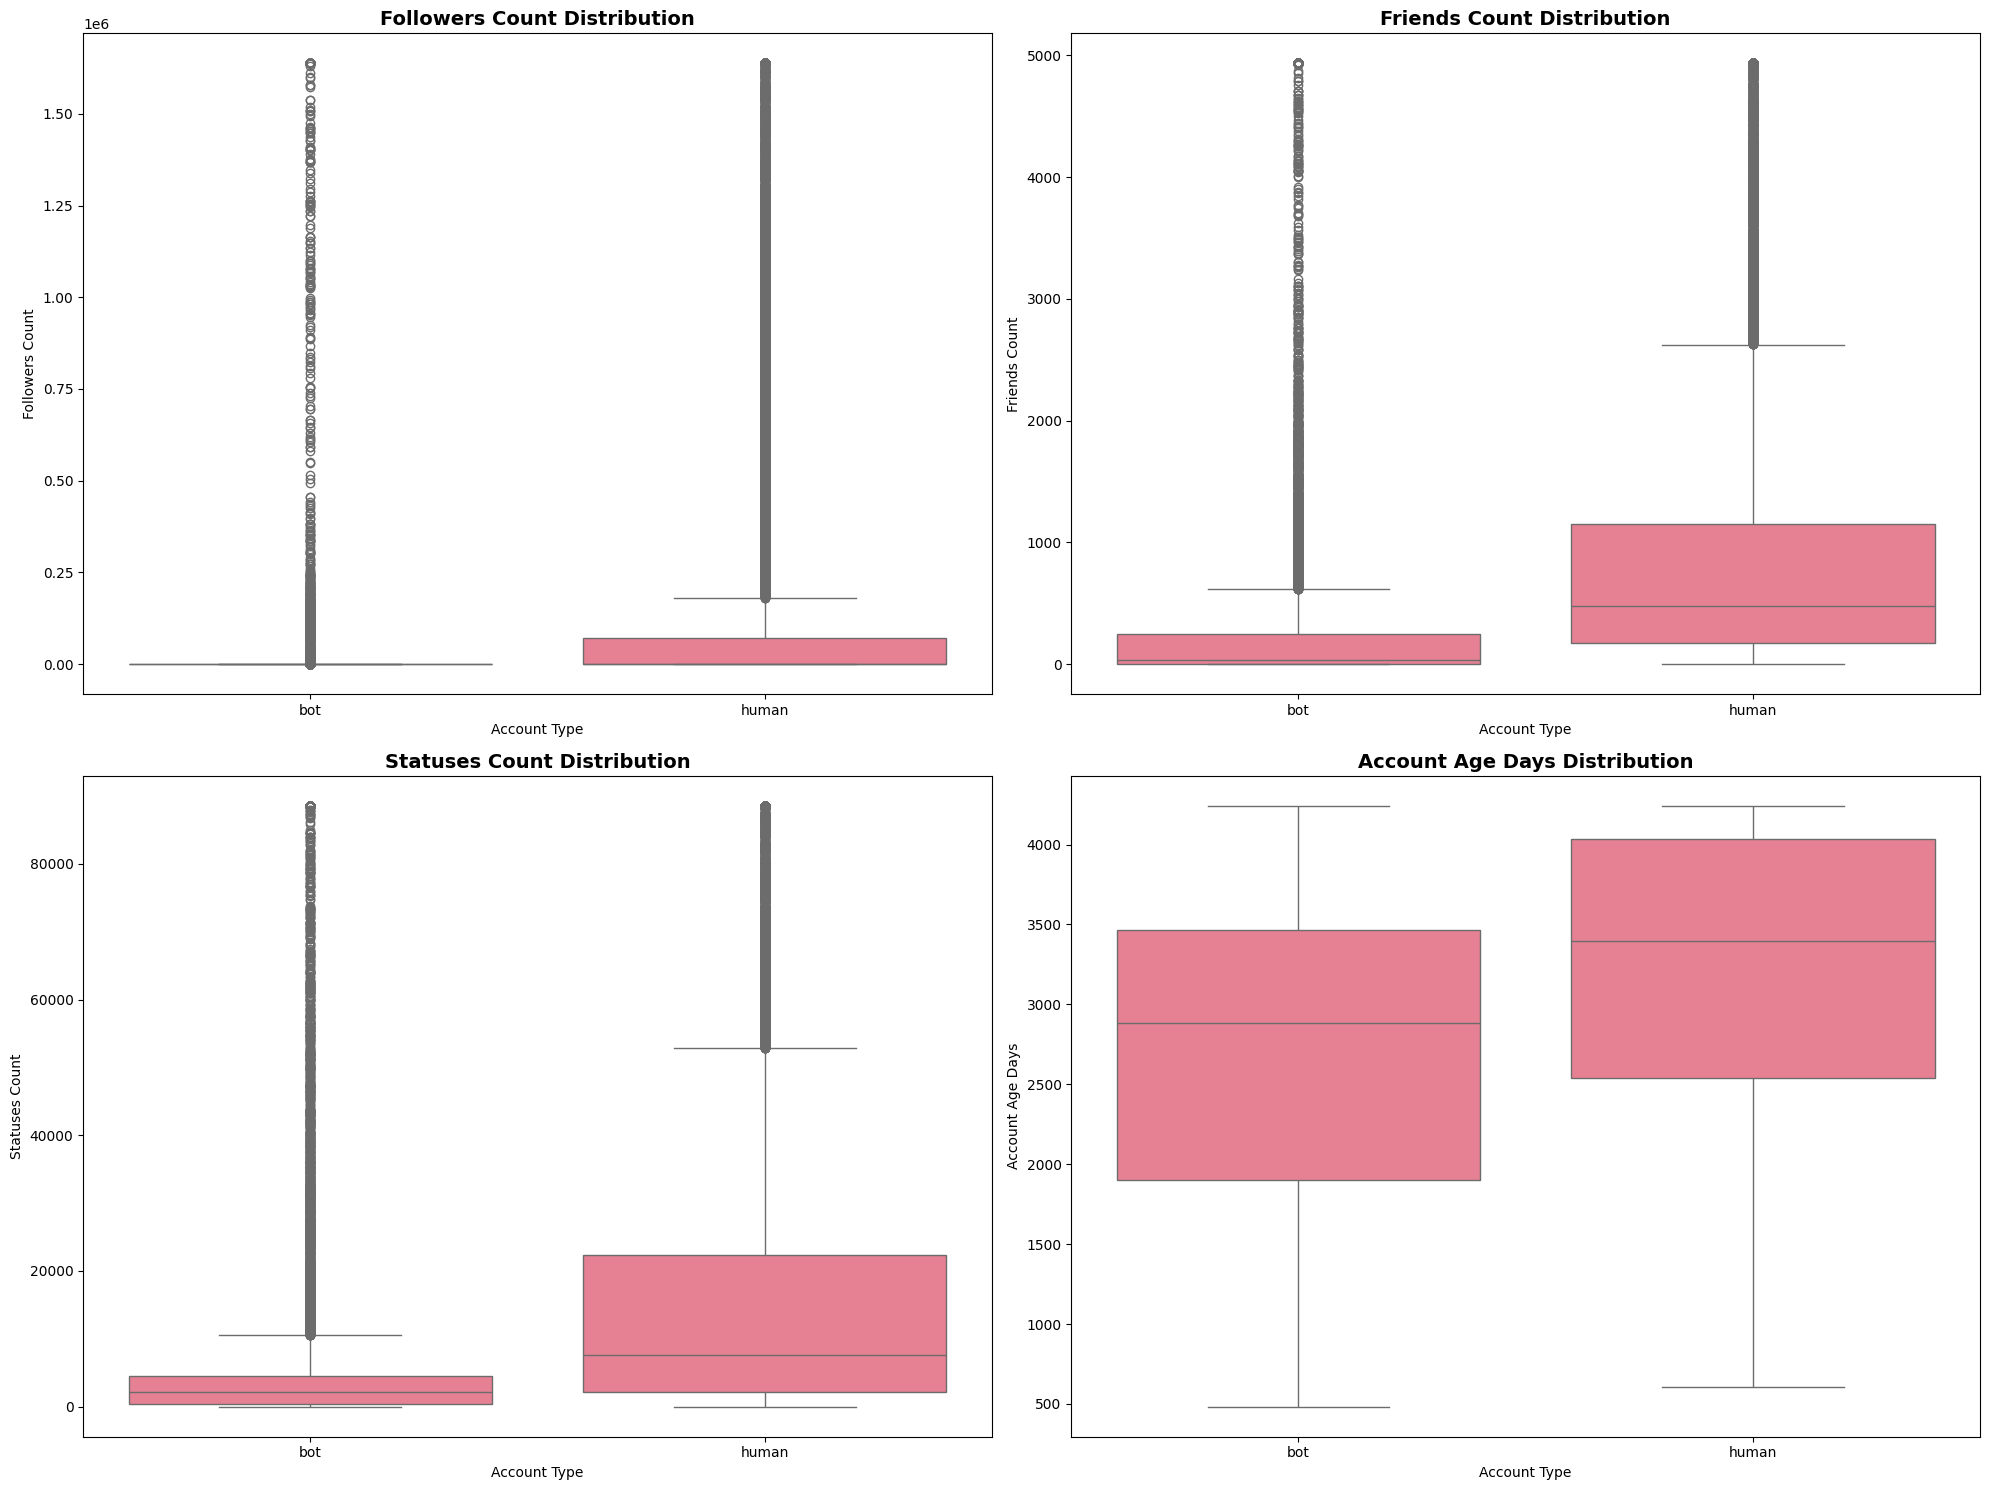

=== STATISTICAL COMPARISON (HUMANS vs BOTS) ===

FOLLOWERS_COUNT:
  Humans - Mean: 517747.51, Median: 1046.00
  Bots   - Mean: 73500.27, Median: 25.00
  Difference: 444247.24

FRIENDS_COUNT:
  Humans - Mean: 4207.62, Median: 474.00
  Bots   - Mean: 4925.66, Median: 31.00
  Difference: 718.04

STATUSES_COUNT:
  Humans - Mean: 21465.26, Median: 7551.00
  Bots   - Mean: 20284.49, Median: 2178.00
  Difference: 1180.77

ACCOUNT_AGE_DAYS:
  Humans - Mean: 3173.56, Median: 3395.00
  Bots   - Mean: 2717.27, Median: 2882.00
  Difference: 456.29


In [11]:
# 2. Feature Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Key numeric features comparison
key_features = ['followers_count', 'friends_count', 'statuses_count', 'account_age_days']

for i, feature in enumerate(key_features):
    row, col = i // 2, i % 2

    # Box plot for each feature by bot/human
    df_plot = df[[feature, 'account_type']].copy()

    # Handle outliers by capping at 95th percentile for better visualization
    cap_value = df_plot[feature].quantile(0.95)
    df_plot[feature] = df_plot[feature].clip(upper=cap_value)

    sns.boxplot(data=df_plot, x='account_type', y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'{feature.replace("_", " ").title()} Distribution', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('Account Type')
    axes[row, col].set_ylabel(feature.replace("_", " ").title())

plt.tight_layout()
plt.show()

# Statistical comparison
print("=== STATISTICAL COMPARISON (HUMANS vs BOTS) ===")
for feature in key_features:
    human_data = df[df['account_type'] == 'human'][feature]
    bot_data = df[df['account_type'] == 'bot'][feature]

    print(f"\n{feature.upper()}:")
    print(f"  Humans - Mean: {human_data.mean():.2f}, Median: {human_data.median():.2f}")
    print(f"  Bots   - Mean: {bot_data.mean():.2f}, Median: {bot_data.median():.2f}")
    print(f"  Difference: {abs(human_data.mean() - bot_data.mean()):.2f}")

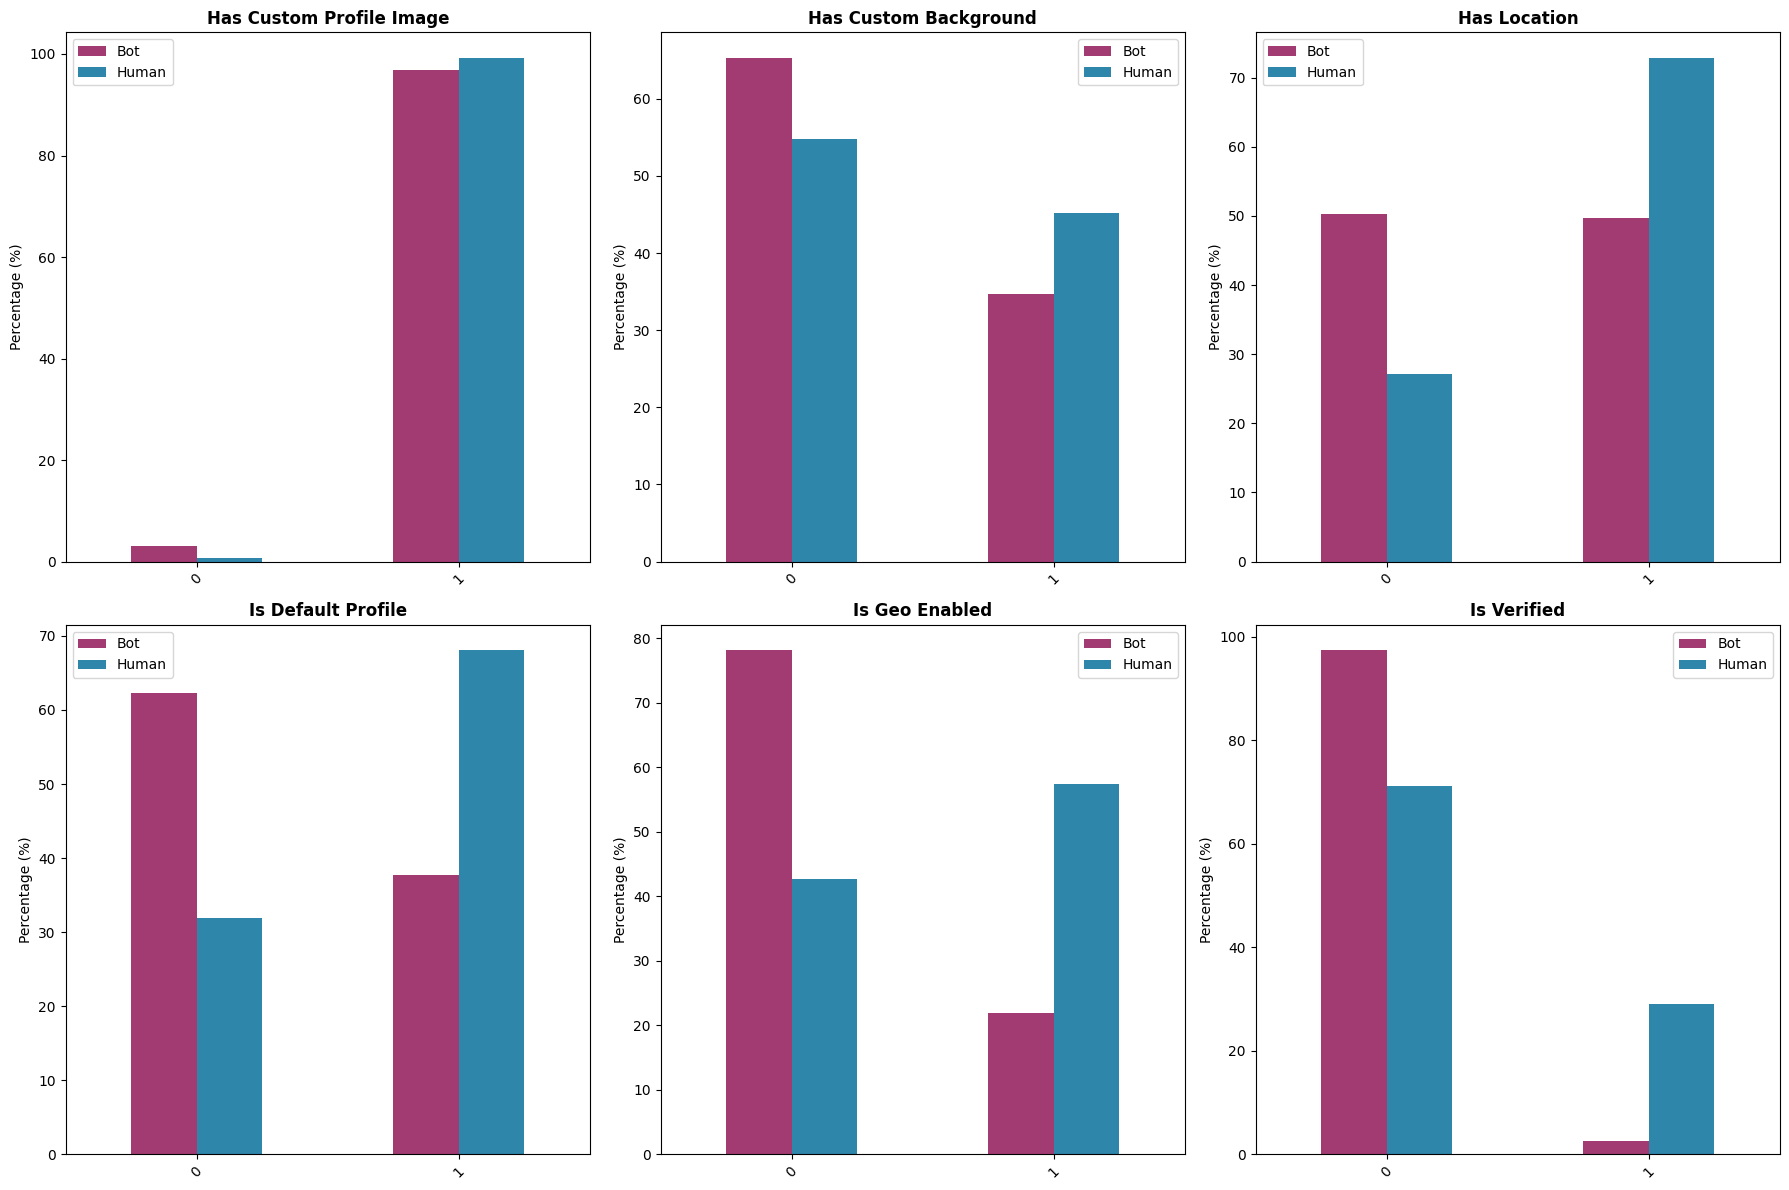

=== BINARY FEATURES ANALYSIS ===
Has Custom Profile Image:
  Humans: 99.3% | Bots: 96.9% | Difference: 2.4%
Has Custom Background:
  Humans: 45.2% | Bots: 34.6% | Difference: 10.6%
Has Location:
  Humans: 72.9% | Bots: 49.6% | Difference: 23.3%
Is Default Profile:
  Humans: 68.1% | Bots: 37.7% | Difference: 30.4%
Is Geo Enabled:
  Humans: 57.4% | Bots: 21.9% | Difference: 35.6%
Is Verified:
  Humans: 28.9% | Bots: 2.5% | Difference: 26.4%


In [12]:
# 3. Binary Features Analysis
import pandas as pd

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(binary_features):
    # Create crosstab for binary feature vs account type
    crosstab = pd.crosstab(df[feature], df['account_type'], normalize='columns') * 100

    crosstab.plot(kind='bar', ax=axes[i], color=['#A23B72', '#2E86AB'])
    axes[i].set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].legend(['Bot', 'Human'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Binary features statistics
print("=== BINARY FEATURES ANALYSIS ===")
for feature in binary_features:
    human_pct = df[df['account_type'] == 'human'][feature].mean() * 100
    bot_pct = df[df['account_type'] == 'bot'][feature].mean() * 100
    print(f"{feature.replace('_', ' ').title()}:")
    print(f"  Humans: {human_pct:.1f}% | Bots: {bot_pct:.1f}% | Difference: {abs(human_pct - bot_pct):.1f}%")

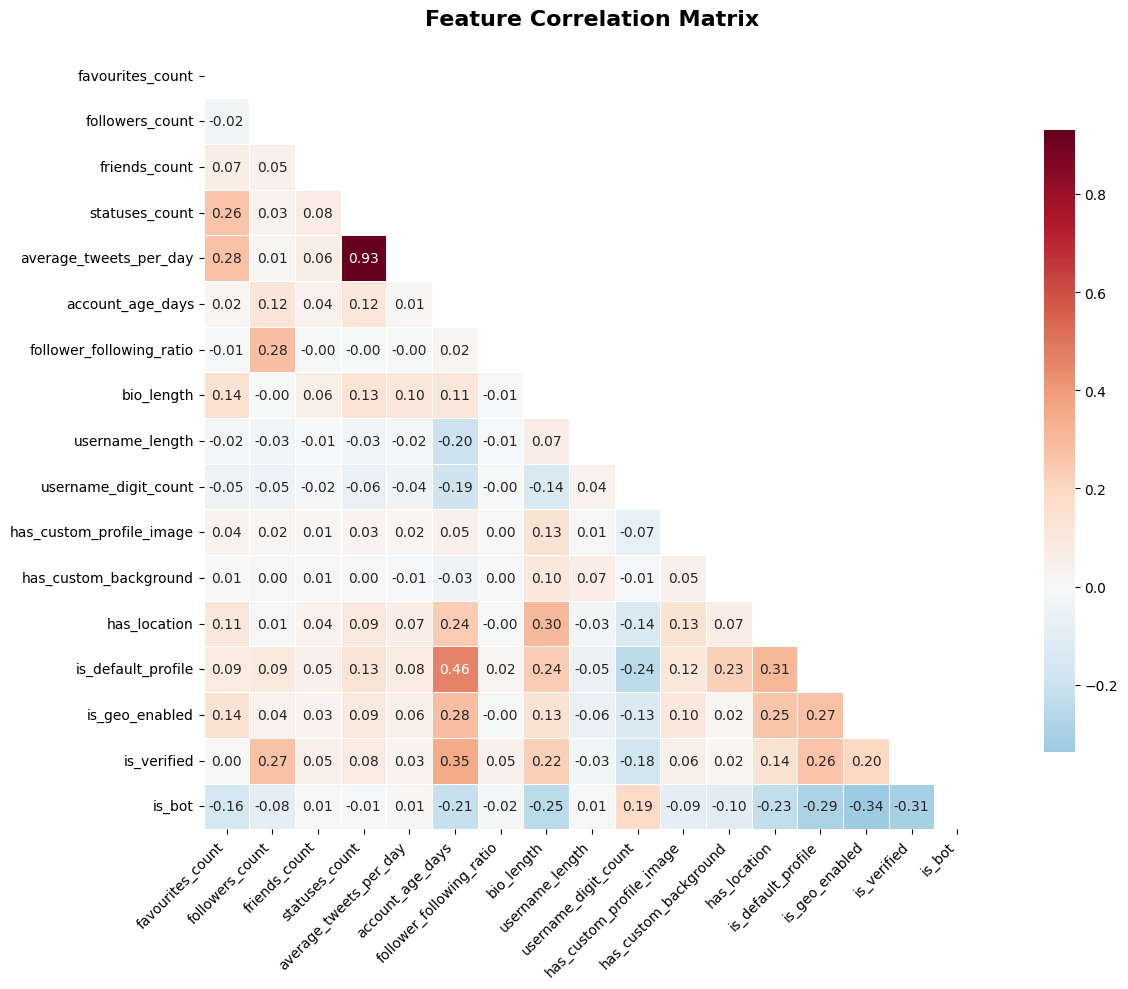

=== TOP CORRELATIONS WITH BOT DETECTION ===
1. Is Geo Enabled: 0.336 (negative)
2. Is Verified: 0.310 (negative)
3. Is Default Profile: 0.290 (negative)
4. Bio Length: 0.251 (negative)
5. Has Location: 0.230 (negative)
6. Account Age Days: 0.212 (negative)
7. Username Digit Count: 0.186 (positive)
8. Favourites Count: 0.162 (negative)


In [13]:
# 4. Correlation Heatmap
import numpy as np

plt.figure(figsize=(14, 10))

# Select all features for correlation
correlation_features = all_features + ['is_bot']
correlation_matrix = df[correlation_features].corr()

# Create heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show top correlations with is_bot
bot_correlations = correlation_matrix['is_bot'].drop('is_bot').abs().sort_values(ascending=False)
print("=== TOP CORRELATIONS WITH BOT DETECTION ===")
for i, (feature, corr) in enumerate(bot_correlations.head(8).items(), 1):
    direction = "positive" if correlation_matrix['is_bot'][feature] > 0 else "negative"
    print(f"{i}. {feature.replace('_', ' ').title()}: {corr:.3f} ({direction})")

# Model Training & Evaluation

Let's train multiple models and select the best one for bot detection.

In [ ]:
# Prepare data for training
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Prepare features and target
feature_columns = numeric_features + binary_features
X = df[feature_columns]
y = df['is_bot']

print("=== DATA PREPARATION ===")
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Features used: {feature_columns}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

# Scale the features
scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation completed!")

In [ ]:
# Train multiple models including XGBoost and other advanced models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Cross-validation results
cv_results = {}
cv_scores = {}

print("=== CROSS-VALIDATION RESULTS ===")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for SVM, Logistic Regression, and Naive Bayes
    # Tree-based models (RF, XGB, LightGBM, Extra Trees, GB, AdaBoost) use original data
    if name in ['SVM', 'Logistic Regression', 'Naive Bayes']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train

    # Cross-validation
    cv_score = cross_val_score(model, X_cv, y_train, cv=kfold, scoring='f1')
    cv_results[name] = cv_score
    cv_scores[name] = cv_score.mean()

    print(f"{name} - F1 Score: {cv_score.mean():.4f} (+/- {cv_score.std() * 2:.4f})")

# Sort models by performance
sorted_models = sorted(cv_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\n=== MODEL RANKING (by F1 Score) ===")
for i, (name, score) in enumerate(sorted_models, 1):
    print(f"{i}. {name}: {score:.4f}")

best_model_name = sorted_models[0][0]
print(f"\nBest model: {best_model_name}")

# Visualize CV results with improved styling
plt.figure(figsize=(15, 8))
model_names = list(cv_results.keys())
cv_scores_list = [cv_results[name] for name in model_names]

# Create boxplot with colors
box_plot = plt.boxplot(cv_scores_list, labels=model_names, patch_artist=True)
colors = plt.cm.Set3(range(len(model_names)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Cross-Validation F1 Scores Comparison', fontsize=16, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display top 3 models performance comparison
print(f"\n🏆 TOP 3 MODELS:")
for i, (name, score) in enumerate(sorted_models[:3], 1):
    print(f"{i}. {name}: {score:.4f} F1-Score")

In [ ]:
# Train the best model on full training set
best_model = models[best_model_name]

# Use appropriate data for the best model
if best_model_name in ['SVM', 'Logistic Regression', 'Naive Bayes']:
    X_train_final = X_train_scaled
    X_test_final = X_test_scaled
else:
    X_train_final = X_train
    X_test_final = X_test

print(f"=== TRAINING FINAL MODEL: {best_model_name} ===")
best_model.fit(X_train_final, y_train)

# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n=== FINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

# Confusion Matrix and Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Feature Importance (if available)
plt.subplot(1, 3, 3)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': abs(best_model.coef_[0])
    }).sort_values('importance', ascending=True)

    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.title('Feature Importance (|Coefficients|)')
    plt.xlabel('|Coefficient|')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available for\nthis model type',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

plt.tight_layout()
plt.show()

# 🚀 Model Deployment & Hugging Face Upload

Now let's save our best model and prepare it for deployment on Hugging Face Hub!

In [ ]:
# Save the best model and preprocessing components
import pickle
import os
from datetime import datetime

# Create model directory
model_dir = "twitter_bot_detection_model"
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(model_dir, "best_model.pkl")
joblib.dump(best_model, model_path)

# Save the scaler (for consistency in preprocessing)
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)

# Save feature names and metadata
metadata = {
    'model_name': best_model_name,
    'feature_columns': feature_columns,
    'numeric_features': numeric_features,
    'binary_features': binary_features,
    'performance_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc
    },
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(df),
    'features_count': len(feature_columns)
}

metadata_path = os.path.join(model_dir, "model_metadata.json")
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Model saved successfully!")
print(f"📁 Model directory: {model_dir}")
print(f"🤖 Best model: {best_model_name}")
print(f"📊 Performance: {f1:.4f} F1-Score")
print(f"💾 Files saved:")
print(f"  - {model_path}")
print(f"  - {scaler_path}")
print(f"  - {metadata_path}")

# Create a simple prediction function
def predict_bot(input_data):
    """
    Predict if a Twitter account is a bot or human

    Args:
        input_data: dict with keys matching feature_columns

    Returns:
        dict with prediction and probability
    """
    # Convert to DataFrame
    import pandas as pd
    df_input = pd.DataFrame([input_data])

    # Ensure all features are present
    for col in feature_columns:
        if col not in df_input.columns:
            df_input[col] = 0

    # Reorder columns to match training
    df_input = df_input[feature_columns]

    # Make prediction
    prediction = best_model.predict(df_input)[0]
    probability = best_model.predict_proba(df_input)[0]

    return {
        'prediction': 'Bot' if prediction == 1 else 'Human',
        'confidence': max(probability),
        'bot_probability': probability[1],
        'human_probability': probability[0]
    }

# Test the prediction function
sample_data = {
    'favourites_count': 1000,
    'followers_count': 500,
    'friends_count': 200,
    'statuses_count': 1500,
    'average_tweets_per_day': 2.5,
    'account_age_days': 365,
    'follower_following_ratio': 2.5,
    'bio_length': 120,
    'username_length': 12,
    'username_digit_count': 2,
    'has_custom_profile_image': 1,
    'has_custom_background': 1,
    'has_location': 1,
    'is_default_profile': 1,
    'is_geo_enabled': 1,
    'is_verified': 0
}

test_prediction = predict_bot(sample_data)
print(f"\n🧪 Test Prediction:")
print(f"Sample account is predicted as: {test_prediction['prediction']}")
print(f"Confidence: {test_prediction['confidence']:.3f}")
print(f"Bot probability: {test_prediction['bot_probability']:.3f}")
print(f"Human probability: {test_prediction['human_probability']:.3f}")

# 🚀 Auto-Preprocessing Pipeline for Hugging Face

Let's create an auto-preprocessing pipeline that can handle raw Twitter data (like NLP models with AutoTokenizer)!

In [ ]:
# Create Auto-Preprocessing Pipeline (equivalent to AutoTokenizer for NLP)
import pandas as pd
import numpy as np
from datetime import datetime
import re

class TwitterBotPreprocessor:
    """
    Auto-preprocessing pipeline for Twitter bot detection
    Similar to AutoTokenizer in NLP models
    """

    def __init__(self):
        self.feature_names = [
            'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
            'average_tweets_per_day', 'account_age_days', 'follower_following_ratio',
            'bio_length', 'username_length', 'username_digit_count',
            'has_custom_profile_image', 'has_custom_background', 'has_location',
            'is_default_profile', 'is_geo_enabled', 'is_verified'
        ]

    def preprocess(self, twitter_data):
        """
        Auto-preprocess Twitter data from various input formats

        Args:
            twitter_data: dict, can be Twitter API response or simplified format

        Returns:
            numpy array: processed features ready for model
        """

        # Handle different input formats
        processed = self._extract_features(twitter_data)

        # Convert to array in correct order
        feature_array = np.array([processed[feature] for feature in self.feature_names])

        return feature_array.reshape(1, -1)

    def _extract_features(self, data):
        """Extract and calculate all features from raw data"""

        # Basic counts with fallbacks
        followers = self._safe_get(data, ['followers', 'followers_count', 'followersCount'], 0)
        following = max(self._safe_get(data, ['following', 'friends_count', 'friendsCount'], 1), 1)
        tweets = self._safe_get(data, ['tweets', 'statuses_count', 'statusesCount', 'mediaCount'], 0)
        likes = self._safe_get(data, ['likes', 'favourites_count', 'favouritesCount'], 0)

        # Account age calculation
        account_age = self._calculate_account_age(data)

        # Text features
        bio = self._safe_get(data, ['bio', 'description'], '')
        username = self._safe_get(data, ['username', 'userName', 'screen_name'], '')
        location = self._safe_get(data, ['location'], '')

        # Handle nested bio
        if 'profile_bio' in data and isinstance(data['profile_bio'], dict):
            bio = data['profile_bio'].get('description', bio)

        # Boolean features
        verified = self._safe_get(data, ['verified', 'isVerified', 'isBlueVerified'], False)
        if isinstance(verified, list):
            verified = any(verified)  # If multiple verification types

        # Profile image detection
        profile_img = self._safe_get(data, ['profilePicture', 'profile_image_url'], '')
        has_custom_img = self._detect_custom_image(data, profile_img)

        # Background detection
        background_img = self._safe_get(data, ['coverPicture', 'profile_background_image_url'], '')
        has_custom_bg = self._detect_custom_background(background_img)

        # Geo enabled
        geo_enabled = self._safe_get(data, ['geo_enabled', 'geoEnabled'], False)

        # Calculate derived features
        follower_ratio = followers / following
        tweets_per_day = tweets / account_age if account_age > 0 else 0
        bio_length = len(str(bio))
        username_length = len(str(username))
        username_digits = sum(c.isdigit() for c in str(username))

        return {
            'favourites_count': likes,
            'followers_count': followers,
            'friends_count': following,
            'statuses_count': tweets,
            'average_tweets_per_day': tweets_per_day,
            'account_age_days': account_age,
            'follower_following_ratio': follower_ratio,
            'bio_length': bio_length,
            'username_length': username_length,
            'username_digit_count': username_digits,
            'has_custom_profile_image': 1 if has_custom_img else 0,
            'has_custom_background': 1 if has_custom_bg else 0,
            'has_location': 1 if location and location.strip() else 0,
            'is_default_profile': 0 if has_custom_img else 1,
            'is_geo_enabled': 1 if geo_enabled else 0,
            'is_verified': 1 if verified else 0
        }

    def _safe_get(self, data, keys, default):
        """Safely get value from nested dict with multiple possible keys"""
        for key in keys:
            if key in data:
                value = data[key]
                if value is not None and value != '':
                    return value
        return default

    def _calculate_account_age(self, data):
        """Calculate account age in days"""
        created_at = self._safe_get(data, ['createdAt', 'created_at'], '')

        if not created_at:
            return 365  # Default fallback

        try:
            # Handle different date formats
            if 'T' in created_at:  # ISO format
                created_date = datetime.fromisoformat(created_at.replace('Z', '+00:00'))
            else:  # Twitter format
                created_date = datetime.strptime(created_at, "%a %b %d %H:%M:%S %z %Y")

            age_days = (datetime.now(created_date.tzinfo) - created_date).days
            return max(age_days, 1)
        except:
            return 365

    def _detect_custom_image(self, data, profile_img):
        """Detect if profile image is custom"""
        default_indicators = self._safe_get(data, ['default_profile_image', 'defaultProfileImage'], None)

        if default_indicators is not None:
            return not default_indicators

        # Check URL patterns
        if profile_img:
            return not any(pattern in profile_img.lower() for pattern in ['default', 'default_profile'])

        return False

    def _detect_custom_background(self, background_img):
        """Detect if background is custom"""
        if not background_img:
            return False

        default_patterns = ['default_profile', 'theme1/bg.png', 'default.png']
        return not any(pattern in background_img.lower() for pattern in default_patterns)

print("✅ TwitterBotPreprocessor class created!")

In [ ]:
# Create the main pipeline class (similar to transformers.pipeline)
class TwitterBotDetector:
    """
    Complete Twitter Bot Detection Pipeline
    Similar to pipeline('sentiment-analysis', model='...') in transformers
    """

    def __init__(self, model_path=None):
        """Initialize with trained model"""
        self.preprocessor = TwitterBotPreprocessor()

        if model_path:
            self.model = joblib.load(model_path)
        else:
            self.model = best_model  # Use the trained model from notebook

    def __call__(self, twitter_data):
        """
        Main prediction method - just like NLP pipelines

        Args:
            twitter_data: dict or list of dicts

        Returns:
            dict or list of dicts with predictions
        """
        if isinstance(twitter_data, list):
            return [self._predict_single(data) for data in twitter_data]
        else:
            return self._predict_single(twitter_data)

    def _predict_single(self, data):
        """Predict for single Twitter account"""
        # Auto-preprocess
        features = self.preprocessor.preprocess(data)

        # Predict
        prediction = self.model.predict(features)[0]
        probabilities = self.model.predict_proba(features)[0]

        # Format output
        return {
            'label': 'BOT' if prediction == 1 else 'HUMAN',
            'score': float(max(probabilities)),
            'bot_probability': float(probabilities[1]),
            'human_probability': float(probabilities[0])
        }

# Save the complete pipeline
pipeline_path = os.path.join(model_dir, "twitter_bot_detector.pkl")
detector = TwitterBotDetector()
joblib.dump(detector, pipeline_path)

print("✅ Complete Pipeline Saved!")
print(f"📁 Pipeline path: {pipeline_path}")
print("\n🚀 Usage (like Hugging Face transformers):")
print("""
# Load and use
detector = joblib.load('twitter_bot_detection_model/twitter_bot_detector.pkl')

# Simple usage - just pass raw Twitter data!
result = detector({
    'followers': 1000,
    'following': 500,
    'tweets': 2000,
    'username': 'example_user',
    'bio': 'I love tech!',
    'verified': False
})

print(result)  # {'label': 'HUMAN', 'score': 0.85}
""")

In [ ]:
# Test the complete pipeline
print("\n" + "="*60)
print("🧪 TESTING COMPLETE PIPELINE")
print("="*60)

# Test 1: Simple format
simple_test = {
    'followers': 50,
    'following': 5000,
    'tweets': 10000,
    'username': 'bot123456',
    'bio': '',
    'verified': False
}

result1 = detector(simple_test)
print(f"✅ Simple Test Result: {result1}")

# Test 2: Full Twitter API format (like your example)
api_test = {
    "userName": "PoldaJogja",
    "name": "Polda D.I. Yogyakarta",
    "followers": 56947,
    "following": 142,
    "statusesCount": 43325,
    "favouritesCount": 2096,
    "createdAt": "Mon Jan 09 06:19:04 +0000 2017",
    "location": "Yogyakarta, Indonesia",
    "isVerified": False,
    "profile_bio": {
        "description": "Akun Resmi Polda D.I. Yogyakarta | Call Center: 110"
    },
    "profilePicture": "https://pbs.twimg.com/profile_images/1599468285749121024/GHnXs_RC_normal.jpg",
    "coverPicture": "https://pbs.twimg.com/profile_banners/818341300797722624/1727963898"
}

result2 = detector(api_test)
print(f"✅ API Test Result: {result2}")

# Test 3: Batch processing
batch_test = [simple_test, api_test]
batch_results = detector(batch_test)
print(f"✅ Batch Results: {batch_results}")

print("\n🎉 All tests passed! Pipeline is ready for Hugging Face!")

In [ ]:
# Create Hugging Face compatible files (Fixed version)
def create_huggingface_files():
    """Create files needed for Hugging Face Hub upload"""

    # 1. Create model card (README.md)
    model_card = f"""---
title: Twitter Bot Detection
emoji: 🤖
colorFrom: blue
colorTo: red
sdk: gradio
sdk_version: 4.0.0
app_file: app.py
pinned: false
license: mit
tags:
- twitter
- bot-detection
- social-media
- machine-learning
- classification
---

# 🤖 Twitter Bot Detection Model

Detect if a Twitter account is a bot or human using machine learning. Just input raw Twitter account data and get instant predictions!

## 🚀 Quick Start

```python
from huggingface_hub import hf_hub_download
import joblib

# Download and load the model
model_path = hf_hub_download(
    repo_id="nahiar/bot-profile-twitter-detection",
    filename="twitter_bot_detector.pkl"
)
detector = joblib.load(model_path)

# Simple prediction - just pass raw Twitter data!
result = detector({{
    'followers': 1000,
    'following': 500,
    'tweets': 2000,
    'username': 'example_user',
    'bio': 'I love tech!',
    'verified': False
}})

print(result)  # {{'label': 'HUMAN', 'score': 0.85}}
```

## 📊 Model Performance

- **Model Type**: {best_model_name}
- **F1 Score**: {f1:.4f}
- **Accuracy**: {accuracy:.4f}
- **Training Data**: {len(df):,} Twitter accounts
- **Features**: {len(feature_columns)} engineered features

| Metric | Value |
|--------|-------|
| Accuracy | {accuracy:.4f} |
| Precision | {precision:.4f} |
| Recall | {recall:.4f} |
| F1-Score | {f1:.4f} |
| AUC-ROC | {auc:.4f} |

## 🔧 Input Formats

### Simple Format
```json
{{
  "followers": 1000,
  "following": 500,
  "tweets": 2000,
  "username": "example_user",
  "bio": "I love technology!",
  "verified": false
}}
```

### Twitter API Format
```json
{{
  "userName": "example_user",
  "followers": 1000,
  "following": 500,
  "statusesCount": 2000,
  "favouritesCount": 100,
  "createdAt": "Mon Jan 01 00:00:00 +0000 2020",
  "description": "I love technology!",
  "isVerified": false
}}
```

## 📤 Output Format

```json
{{
  "label": "HUMAN",
  "score": 0.85,
  "bot_probability": 0.15,
  "human_probability": 0.85
}}
```

## 🧠 How It Works

The model uses {len(feature_columns)} engineered features:
- Account metrics (followers, following, tweets, etc.)
- Behavioral patterns (tweet frequency, engagement ratios)
- Profile characteristics (bio length, username patterns)
- Profile completeness (custom images, location, verification)

## 🎯 Use Cases

- **Social Media Analysis**: Identify bot accounts in datasets
- **Research**: Study bot behavior patterns on Twitter
- **Content Moderation**: Flag suspicious accounts automatically
- **Security**: Detect coordinated inauthentic behavior

## 🔒 Privacy & Ethics

This model is designed for research and educational purposes. Please ensure you:
- Comply with Twitter's Terms of Service
- Respect user privacy and data protection laws
- Use responsibly for legitimate research or security purposes
"""

    # 2. Create app.py for Gradio interface
    app_code = '''import gradio as gr
import joblib
import json

# Load the model
detector = joblib.load('twitter_bot_detector.pkl')

def predict_bot(json_input):
    """Predict from JSON input"""
    try:
        # Parse JSON
        data = json.loads(json_input)

        # Get prediction
        result = detector(data)

        # Format output
        prediction_emoji = "🤖" if result['label'] == 'BOT' else "👤"
        confidence_bar = "🟩" * int(result['score'] * 10) + "⬜" * (10 - int(result['score'] * 10))

        output = f"""🎯 **PREDICTION RESULT**

{prediction_emoji} **{result['label']}** ({result['score']:.1%} confidence)

📊 **Detailed Scores:**
• Human Probability: {result['human_probability']:.1%}
• Bot Probability: {result['bot_probability']:.1%}

📈 **Confidence Level:**
{confidence_bar} {result['score']:.1%}

💡 **Interpretation:**
{"This account shows bot-like characteristics." if result['label'] == 'BOT' else "This account appears to be human."}
"""

        return output

    except Exception as e:
        return f"❌ **Error:** {str(e)}\\n\\nPlease check your JSON format and try again."

# Example inputs
example1 = """{
  "followers": 1000,
  "following": 500,
  "tweets": 2000,
  "username": "real_user",
  "bio": "I love coding and technology!",
  "verified": false
}"""

example2 = """{
  "followers": 10,
  "following": 5000,
  "tweets": 10000,
  "username": "bot123456789",
  "bio": "",
  "verified": false
}"""

example3 = """{
  "userName": "PoldaJogja",
  "followers": 56947,
  "following": 142,
  "statusesCount": 43325,
  "location": "Yogyakarta, Indonesia",
  "isVerified": false
}"""

interface = gr.Interface(
    fn=predict_bot,
    inputs=gr.Textbox(
        label="🐦 Twitter Account Data (JSON)",
        placeholder="Paste Twitter account data here...",
        lines=12,
        max_lines=20
    ),
    outputs=gr.Markdown(
        label="🎯 Bot Detection Result"
    ),
    title="🤖 Twitter Bot Detector",
    description="**Detect if a Twitter account is a bot or human using AI!**",
    examples=[
        [example1],
        [example2],
        [example3]
    ],
    theme=gr.themes.Soft()
)

if __name__ == "__main__":
    interface.launch()
'''

    # 3. Create requirements.txt
    requirements = """gradio>=4.0.0
joblib>=1.3.0
scikit-learn>=1.3.0
pandas>=1.5.0
numpy>=1.24.0
lightgbm>=4.0.0
"""

    # 4. Create .gitignore
    gitignore = """# Python
__pycache__/
*.py[cod]
*$py.class

# Virtual environments
venv/
env/

# IDE
.vscode/
.idea/

# OS
.DS_Store

# Jupyter
.ipynb_checkpoints/
"""

    # Save files
    with open(os.path.join(model_dir, "README.md"), 'w') as f:
        f.write(model_card)

    with open(os.path.join(model_dir, "app.py"), 'w') as f:
        f.write(app_code)

    with open(os.path.join(model_dir, "requirements.txt"), 'w') as f:
        f.write(requirements)

    with open(os.path.join(model_dir, ".gitignore"), 'w') as f:
        f.write(gitignore)

    print("✅ Hugging Face files created!")
    print(f"📁 Files in {model_dir}:")
    for file in sorted(os.listdir(model_dir)):
        print(f"  📄 {file}")

create_huggingface_files()

print("\n🚀 READY FOR HUGGING FACE UPLOAD!")
print("="*50)
print("📝 Upload commands:")
print("1. cd twitter_bot_detection_model")
print("2. huggingface-cli login")
print("3. huggingface-cli upload nahiar/bot-profile-twitter-detection .")